## Problem Statement ##  
Project investigates the problem of efficiently synthesizing and summarizing the vast amount of research published on arXiv across multiple categories

With the rapid increase in scholarly papers, particularly in fields like computer science, physics, and mathematics, researchers and practitioners face challenges in keeping up with the latest advancements and trends. This information overload can hinder effective decision-making, research synthesis, and knowledge dissemination.  

My project, using the BART model across multiple arXiv categories, addresses these challenges by exploring how well a general-purpose transformer model can perform when applied to diverse research domains. This contributes valuable insights to the field and offers potential for further refinements and improvements in automated research summarization.

## Data Extraction ##  
The primary data source for your project is arXiv.org, a well-known preprint repository that provides open-access research papers across various scientific fields.
 arXiv.org provides a library which can be imported to download the PDF for each paper. Since the arxiv repository is huge, this project is focussed in extracting data for 4 categories with 100 papers in each category. Catgories Listed are :    
 "NLP": "cs.CL",  # Computation and Language  
"Machine Learning": "cs.LG",  # Machine Learning  
"AI": "cs.AI",  # Artificial Intelligence  
"Data Intelligence": "cs.IR",  # Information Retrieval  
"Data Mining": "cs.DM"  # Data Mining  

Step 1: Creating the directory structure for downloading the PDF from arxiv

In [3]:
import arxiv
import requests
import os

# Create a directory to store the downloaded papers
os.makedirs('arxiv_papers', exist_ok=True)

# List of target categories
categories = {
    "NLP": "cs.CL",  # Computation and Language
    "Machine Learning": "cs.LG",  # Machine Learning
    "AI": "cs.AI",  # Artificial Intelligence
    "Data Intelligence": "cs.IR",  # Information Retrieval
    "Data Mining": "cs.DM"  # Data Mining
}


Step 2: Downloading PDF files in there relevant categories with there titles.  
This would involve downlaoding PDF from the URL's in the aRxiv repo and will check for errors if any URL's failed to download.

In [5]:
# Function to download PDFs with titles as filenames
def download_papers_with_titles(categories, save_dir='arxiv_papers', max_papers=100):
    for category_name, category_code in categories.items():
        # Search for papers in the specified category
        search = arxiv.Search(
            query=f"cat:{category_code}",
            max_results=max_papers,  # Set to 100 papers per category
            sort_by=arxiv.SortCriterion.Relevance
        )
        
        # Create a subdirectory for each category
        category_dir = os.path.join(save_dir, category_name)
        os.makedirs(category_dir, exist_ok=True)
        
        for result in search.results():
            title = result.title
            pdf_url = result.pdf_url

            # Clean the title for use as a filename
            safe_title = "".join(char for char in title if char.isalnum() or char in " _-")
            safe_title = safe_title[:100]  # Limit title length if necessary
            file_path = os.path.join(category_dir, f"{safe_title}.pdf")
            
            # Download the PDF
            try:
                response = requests.get(pdf_url, stream=True)
                response.raise_for_status()
                
                with open(file_path, 'wb') as file:
                    for chunk in response.iter_content(chunk_size=8192):
                        file.write(chunk)
                
                print(f"Downloaded: {safe_title}.pdf in {category_name} category")
            
            except requests.exceptions.RequestException as e:
                print(f"Failed to download {title}: {e}")

# Execute the download function
download_papers_with_titles(categories, max_papers=100)

C:\Users\NEHA\AppData\Local\Temp\ipykernel_27036\1548395272.py:15: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


Downloaded: Linear Segmentation and Segment Significance.pdf in NLP category
Downloaded: Modelling Users Intentions and Structure in Spoken Dialog.pdf in NLP category
Downloaded: A Lexicalized Tree Adjoining Grammar for English.pdf in NLP category
Downloaded: Prefix Probabilities from Stochastic Tree Adjoining Grammars.pdf in NLP category
Downloaded: Conditions on Consistency of Probabilistic Tree Adjoining Grammars.pdf in NLP category
Downloaded: Separating Dependency from Constituency in a Tree Rewriting System.pdf in NLP category
Downloaded: Incremental Parser Generation for Tree Adjoining Grammars.pdf in NLP category
Downloaded: A Freely Available Morphological Analyzer Disambiguator and Context Sensitive Lemmatizer for German.pdf in NLP category
Downloaded: Processing Unknown Words in HPSG.pdf in NLP category
Downloaded: Computing Declarative Prosodic Morphology.pdf in NLP category
Downloaded: On the Evaluation and Comparison of Taggers The Effect of Noise in Testing Corpora.pdf i

## Data Pre-processing
Data pre-processing is very crucial for feeding raw data into models like BART. Main steps in that is :  
PDF to Text Extraction - It allows you to work directly with text data for further processing, such as tokenization or summarization. 


Step 1: PDF to Text Extraction  
This was a complicated step , as we have combine various methods to extract the data correctly as text:  

1. The extract_text_with_pymupdf function uses PyMuPDF to open each PDF and extract text page by page. This is the primary method due to PyMuPDF's generally reliable handling of structured PDFs.  
2. If PyMuPDF extraction fails or returns poor-quality results, the extract_text_with_pdfminer function attempts extraction using pdfminer.six, which can handle PDFs with complex layouts differently and may improve text output.  
3. For PDFs where neither PyMuPDF nor PDFMiner provides satisfactory results, the extract_text_with_ocr function uses Tesseract OCR. It first converts each PDF page to an image and then extracts text from these images, which is particularly useful for scanned or image-based PDFs.  
4. After extraction, the text is cleaned using the clean_text function to remove unwanted characters and whitespace, enhancing readability and preparing the text for further processing.  

Extracted texts are now saved in seperate folder

In [ ]:
!pip install pdfminer.six pytesseract pdf2image


In [1]:
import os
import fitz  # PyMuPDF
import logging
from pdfminer.high_level import extract_text
import re
import pytesseract
from pdf2image import convert_from_path

# Configure logging
logging.basicConfig(filename='extraction_errors.log', level=logging.ERROR)

# Function to clean text after extraction
def clean_text(text):
    # Remove unwanted spaces, newlines, and strange character codes
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[\x0c\x0b\x0e]', '', text)
    return text.strip()

# Function to extract text using PyMuPDF
def extract_text_with_pymupdf(pdf_path):
    text = ""
    try:
        with fitz.open(pdf_path) as doc:
            for page in doc:
                text += page.get_text()
    except Exception as e:
        logging.error(f"PyMuPDF failed for {pdf_path}: {e}")
    return text

# Fallback function to extract text using pdfminer.six
def extract_text_with_pdfminer(pdf_path):
    try:
        return extract_text(pdf_path)
    except Exception as e:
        logging.error(f"PDFMiner failed for {pdf_path}: {e}")
        return ""

# OCR-based text extraction using Tesseract as a last resort
def extract_text_with_ocr(pdf_path):
    text = ""
    try:
        pages = convert_from_path(pdf_path)
        for page in pages:
            text += pytesseract.image_to_string(page)
    except Exception as e:
        logging.error(f"OCR extraction failed for {pdf_path}: {e}")
    return text

# Function to extract text with fallback mechanisms
def extract_text_from_pdf(pdf_path):
    text = extract_text_with_pymupdf(pdf_path)
    if not text.strip():  # Fallback to pdfminer if PyMuPDF result is empty or low quality
        text = extract_text_with_pdfminer(pdf_path)
    if not text.strip():  # Fallback to OCR if both PyMuPDF and PDFMiner fail
        text = extract_text_with_ocr(pdf_path)
    
    # Clean the extracted text
    return clean_text(text)

# Process all downloaded papers
categories = {
    "NLP": "cs.CL",
    "Machine Learning": "cs.LG",
    "AI": "cs.AI",
    "Data Intelligence": "cs.IR",
    "Data Mining": "cs.DM"
}

for category in categories.keys():
    paper_dir = f'./arxiv_papers/{category}'
    os.makedirs(f'./arxiv_text/{category}', exist_ok=True)  # Create a directory for extracted text

    for i, pdf_file in enumerate(os.listdir(paper_dir), start=1):
        if pdf_file.endswith(".pdf"):
            pdf_path = os.path.join(paper_dir, pdf_file)
            try:
                print(f"Extracting text from {pdf_path} ({i}/{len(os.listdir(paper_dir))})...")
                text = extract_text_from_pdf(pdf_path)
                
                # Save extracted text with utf-8 encoding
                text_path = f"./arxiv_text/{category}/{pdf_file.replace('.pdf', '.txt')}"
                with open(text_path, 'w', encoding='utf-8') as f:
                    f.write(text)
                print(f"Saved text to {text_path}")
            except Exception as e:
                logging.error(f"Failed to extract text from {pdf_file}: {e}")
                print(f"Failed to extract text from {pdf_file}: {e}")


Extracting text from ./arxiv_papers/NLP\A Bootstrap Approach to Automatically Generating Lexical Transfer Rules.pdf (1/98)...
Saved text to ./arxiv_text/NLP/A Bootstrap Approach to Automatically Generating Lexical Transfer Rules.txt
Extracting text from ./arxiv_papers/NLP\A Compact Architecture for Dialogue Management Based on Scripts and Meta-Outputs.pdf (2/98)...
Saved text to ./arxiv_text/NLP/A Compact Architecture for Dialogue Management Based on Scripts and Meta-Outputs.txt
Extracting text from ./arxiv_papers/NLP\A Comparison of the XTAG and CLE Grammars for English.pdf (3/98)...
Saved text to ./arxiv_text/NLP/A Comparison of the XTAG and CLE Grammars for English.txt
Extracting text from ./arxiv_papers/NLP\A Computational Memory and Processing Model for Processing for Prosody.pdf (4/98)...
Saved text to ./arxiv_text/NLP/A Computational Memory and Processing Model for Processing for Prosody.txt
Extracting text from ./arxiv_papers/NLP\A Finite State and Data-Oriented Method for Grap

Step 2: Cleaned text pre-processing steps  
1.  Text Cleaning and Normalization  -  Remove Non-Textual Elements, Lowercase Conversion, Remove Special Characters and Punctuation, Whitespace Normalization
2. Sentence Splitting - Since BART operates at the sentence level, segment the text into individual sentences. This can improve the model’s comprehension by feeding it smaller, coherent units of text.Libraries like nltk or spacy provide accurate sentence tokenizers that can handle complex sentence boundaries.  
3.  Stop Words Removal - Although BART can handle stop words, removing them can sometimes reduce noise, especially if your extracted text has a lot of filler content. However, be cautious as BART is trained on general English, which includes stop words.  
4. Lemmatization or Stemming - This step helps in reducing vocabulary size, making it easier for the BART model to process the text consistently.  
5. Text Truncation or Chunking -  BART has a maximum token limit (usually around 1024 tokens). If your documents exceed this, truncate them to fit within the model’s limits or chunk them into smaller sections.
6. Document Structure Encoding - Retain document structure by tagging sections like “Abstract,” “Introduction,” and “Conclusion” before summarization. This provides context that BART can leverage.   
7. Summarization Prompt - For Using a pre-trained or fine-tuned BART model for summarization, framing the input with prompts like “Summarize:” or using headings can improve the model’s focus.

In [21]:
import os
import re
import nltk
import spacy
import logging
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

# Configure logging
logging.basicConfig(filename='preprocessing_warnings.log', level=logging.WARNING)

# Set reduction threshold
reduction_threshold = 30.0

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load SpaCy model for lemmatization
nlp = spacy.load('en_core_web_sm')

# Define Preprocessing Functions
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?()\-:]', '', text)
    return text.strip()

def split_into_sentences(text):
    return sent_tokenize(text)

def remove_citations(text):
    text = re.sub(r'\[\d+\]', '[citation]', text)
    text = re.sub(r'\([A-Za-z]+ et al., \d{4}\)', '[citation]', text)
    return text

def preprocess_text(text):
    text = normalize_text(text)
    text = remove_citations(text)
    sentences = split_into_sentences(text)
    return ' '.join(sentences)

def identify_and_tag_sections(text):
    tagged_text = ""
    section_patterns = {
        'Abstract': r'\babstract\b.*?(?=\b(introduction|1\s+introduction|related\swork)\b)',
        'Introduction': r'\b(introduction|1\s+introduction)\b.*?(?=\b(conclusion|2\s+conclusion|related\swork|summary|discussion)\b)',
        'Conclusion': r'\b(conclusion|discussion|summary)\b.*?(?=\b(references|appendix|acknowledgments)\b)',
        'Related Work': r'\b(related\swork|previous\swork|background)\b.*?(?=\b(introduction|conclusion|discussion|summary|references)\b)'
    }
    for section, pattern in section_patterns.items():
        match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        if match:
            section_text = match.group(0).strip()
            tagged_text += f"\n\n<{section}>\n{section_text}\n</{section}>"
    main_body = re.sub('|'.join(section_patterns.values()), '', text, flags=re.IGNORECASE | re.DOTALL).strip()
    if main_body:
        tagged_text += f"\n\n<MainBody>\n{main_body}\n</MainBody>"
    return tagged_text

def chunk_text(text, max_tokens=900):
    sentences = sent_tokenize(text)
    current_chunk = []
    current_length = 0
    chunks = []
    for sentence in sentences:
        length = len(sentence.split())
        if current_length + length <= max_tokens:
            current_chunk.append(sentence)
            current_length += length
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [sentence]
            current_length = length
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    return chunks

# Directory paths
input_dir = './arxiv_text'
output_dir = './arxiv_preprocessed_text'
os.makedirs(output_dir, exist_ok=True)

# Category structure
categories = {
    "NLP": "cs.CL",
    "Machine Learning": "cs.LG",
    "AI": "cs.AI",
    "Data Intelligence": "cs.IR",
    "Data Mining": "cs.DM"
}

# Initialize an empty list for the DataFrame
reduction_data = []
# Processing Loop
for category in categories.keys():
    input_category_dir = os.path.join(input_dir, category)
    output_category_dir = os.path.join(output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    for i, text_file in enumerate(os.listdir(input_category_dir), start=1):
        if text_file.endswith(".txt"):
            text_path = os.path.join(input_category_dir, text_file)
            try:
                # Load and preprocess the original text
                with open(text_path, 'r', encoding='utf-8') as file:
                    original_text = file.read()
                original_word_count = len(original_text.split())
                original_char_count = len(original_text)

                # Apply preprocessing steps
                processed_text = preprocess_text(original_text)
                tagged_text = identify_and_tag_sections(processed_text)
                chunked_sections = chunk_text(tagged_text)
                final_text = "Summarize:\n" + "\n".join(chunked_sections)

                # Calculate reduction
                preprocessed_word_count = len(final_text.split())
                preprocessed_char_count = len(final_text)
                word_reduction = ((original_word_count - preprocessed_word_count) / original_word_count) * 100
                char_reduction = ((original_char_count - preprocessed_char_count) / original_char_count) * 100

                # Append data for the DataFrame
                reduction_data.append({
                    "Category": category,
                    "File Name": text_file,
                    "Original Word Count": original_word_count,
                    "Preprocessed Word Count": preprocessed_word_count,
                    "Word Reduction (%)": word_reduction,
                    "Original Character Count": original_char_count,
                    "Preprocessed Character Count": preprocessed_char_count,
                    "Character Reduction (%)": char_reduction,
                    "Exceeds Threshold": word_reduction > reduction_threshold or char_reduction > reduction_threshold
                })

                # Save the final preprocessed text to the category folder
                output_file_path = os.path.join(output_category_dir, text_file)
                with open(output_file_path, 'w', encoding='utf-8') as output_file:
                    output_file.write(final_text)
                
                print(f"Saved pre-processed text to {output_file_path}")

            except Exception as e:
                logging.error(f"Failed to process {text_file}: {e}")

# Create the DataFrame and display it
reduction_df = pd.DataFrame(reduction_data)
print(reduction_df)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saved pre-processed text to ./arxiv_preprocessed_text\NLP\A Bootstrap Approach to Automatically Generating Lexical Transfer Rules.txt
Saved pre-processed text to ./arxiv_preprocessed_text\NLP\A Compact Architecture for Dialogue Management Based on Scripts and Meta-Outputs.txt
Saved pre-processed text to ./arxiv_preprocessed_text\NLP\A Comparison of the XTAG and CLE Grammars for English.txt
Saved pre-processed text to ./arxiv_preprocessed_text\NLP\A Computational Memory and Processing Model for Processing for Prosody.txt
Saved pre-processed text to ./arxiv_preprocessed_text\NLP\A Finite State and Data-Oriented Method for Grapheme to Phoneme Conversion.txt
Saved pre-processed text to ./arxiv_preprocessed_text\NLP\A Flexible Shallow Approach to Text Generation.txt
Saved pre-processed text to ./arxiv_preprocessed_text\NLP\A Formal Framework for Linguistic Annotation.txt
Saved pre-processed text to ./arxiv_preprocessed_text\NLP\A Freely Available Morphological Analyzer Disambiguator and Con

## Data Visualisation ##  
Reduction in data

C:\Users\NEHA\AppData\Local\Temp\ipykernel_7904\299277844.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Category", y="Word Reduction (%)", data=reduction_df, ci=None, palette="viridis")
C:\Users\NEHA\AppData\Local\Temp\ipykernel_7904\299277844.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y="Word Reduction (%)", data=reduction_df, ci=None, palette="viridis")


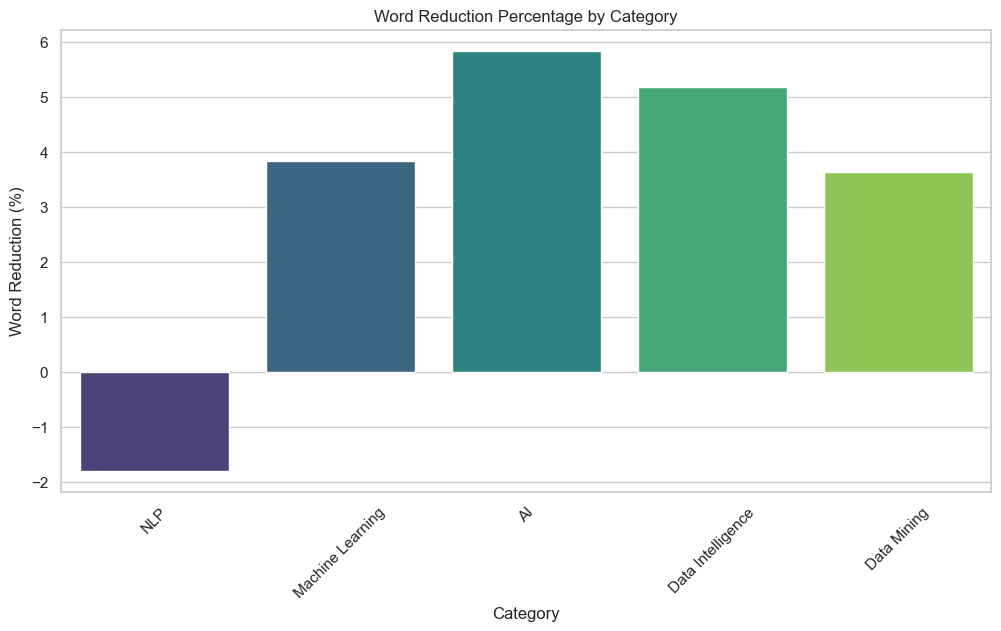

C:\Users\NEHA\AppData\Local\Temp\ipykernel_7904\299277844.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Category", y="Character Reduction (%)", data=reduction_df, ci=None, palette="magma")
C:\Users\NEHA\AppData\Local\Temp\ipykernel_7904\299277844.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y="Character Reduction (%)", data=reduction_df, ci=None, palette="magma")


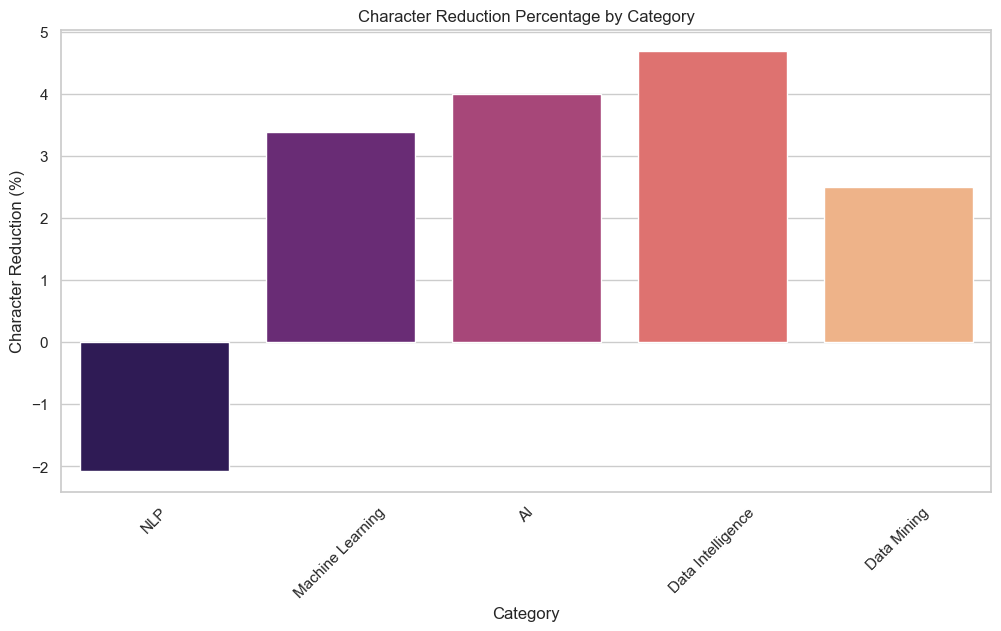

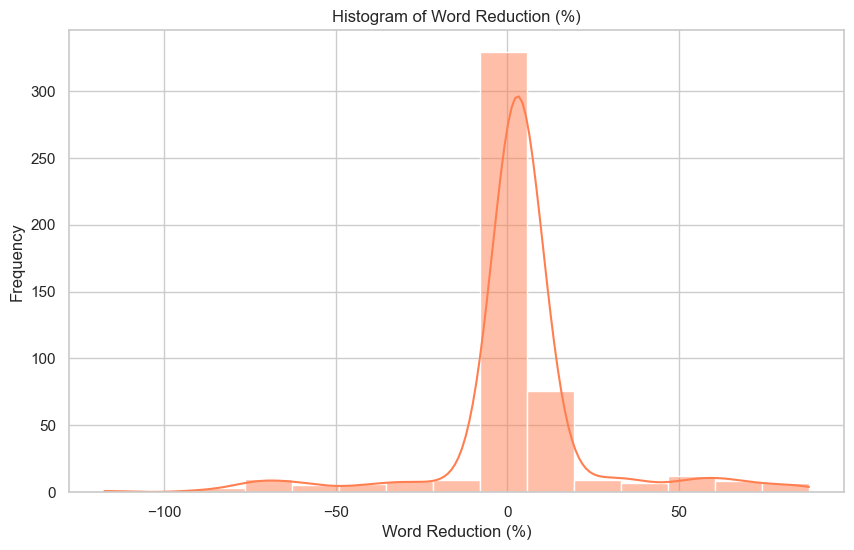

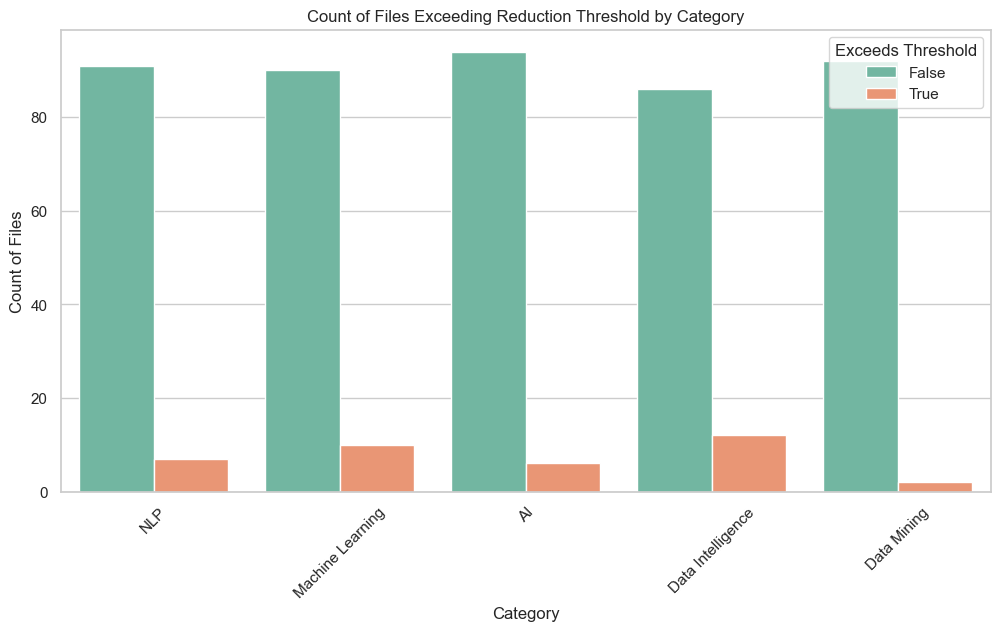

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# 1. Bar Plot: Word Reduction Percentage by Category
plt.figure(figsize=(12, 6))
sns.barplot(x="Category", y="Word Reduction (%)", data=reduction_df, ci=None, palette="viridis")
plt.title("Word Reduction Percentage by Category")
plt.xlabel("Category")
plt.ylabel("Word Reduction (%)")
plt.xticks(rotation=45)
plt.show()

# 2. Bar Plot: Character Reduction Percentage by Category
plt.figure(figsize=(12, 6))
sns.barplot(x="Category", y="Character Reduction (%)", data=reduction_df, ci=None, palette="magma")
plt.title("Character Reduction Percentage by Category")
plt.xlabel("Category")
plt.ylabel("Character Reduction (%)")
plt.xticks(rotation=45)
plt.show()

# 4. Histogram: Overall Distribution of Word Reduction Percentage
plt.figure(figsize=(10, 6))
sns.histplot(reduction_df["Word Reduction (%)"], bins=15, kde=True, color="coral")
plt.title("Histogram of Word Reduction (%)")
plt.xlabel("Word Reduction (%)")
plt.ylabel("Frequency")
plt.show()

# 5. Count Plot: Files Exceeding Threshold by Category
plt.figure(figsize=(12, 6))
sns.countplot(x="Category", hue="Exceeds Threshold", data=reduction_df, palette="Set2")
plt.title("Count of Files Exceeding Reduction Threshold by Category")
plt.xlabel("Category")
plt.ylabel("Count of Files")
plt.xticks(rotation=45)
plt.legend(title="Exceeds Threshold", loc="upper right")
plt.show()


### Analysis:  
The visualizations suggest that text preprocessing was relatively mild across most files, with significant reductions being rare. Certain categories like AI and Data Intelligence benefited more from word reduction, which may indicate that these fields contained more redundant information that could be streamlined. NLP, in contrast, showed minimal reduction or even a slight increase in word count, suggesting domain-specific requirements that retain or add linguistic elements. The threshold analysis further supports the view that while most files saw minimal reductions, a few outliers required more aggressive processing.  
Across all categories, the majority of files did not exceed the reduction threshold, shown by the dominant green bars, which indicates that extensive word reduction was not common.  
However, each category has a small percentage of files that did exceed the threshold (indicated in orange). This suggests that a subset of files in each category required more intensive text cleaning, possibly due to higher verbosity or redundancy.  

Step 3: Creating CSV files for the input into BART model -Creating a CSV file with key attributes for each paper will provide structured input and metadata that can be valuable for analysis, benchmarking, and even potentially fine-tuning the summarization model.
For each paper, following metadata:  
Title: Often available directly in the file name or metadata from arXiv.  
Category: Available from your directory structure.  
Publication Date: This may need to be fetched from the arXiv metadata if not already available.  
Authors: Also likely available in the arXiv metadata.  
Abstract: If you have this separately, you can add it; otherwise, you might use the first paragraph or a specific tagged section in your pre-processed data as a placeholder.  

In [26]:
import os
import pandas as pd
import arxiv

# Initialize an empty list to store paper data
paper_data = []

# Define directory paths
input_dir = './arxiv_preprocessed_text'

# Loop through each category directory
for category in os.listdir(input_dir):
    category_dir = os.path.join(input_dir, category)
    for file_name in os.listdir(category_dir):
        file_path = os.path.join(category_dir, file_name)
        
        # Extract title from the filename (assuming the title is part of the filename)
        title = file_name.replace('.txt', '').replace('_', ' ') 
        
        # Read the full text
        with open(file_path, 'r', encoding='utf-8') as file:
            full_text = file.read()
        
        # Extract abstract (assuming tagged in text)
        abstract_start = full_text.find("<Abstract>")
        abstract_end = full_text.find("</Abstract>")
        abstract = full_text[abstract_start + len("<Abstract>"):abstract_end].strip() if abstract_start != -1 else "N/A"
        
        # Query arXiv for publication date and authors
        try:
            # Query arXiv using the title
            search = arxiv.Search(
                query=f'ti:"{title}"',
                max_results=1,
                sort_by=arxiv.SortCriterion.Relevance
            )
            
            # Fetch the first result, if available
            paper = next(search.results(), None)
            
            # Extract authors and publication date
            if paper:
                authors = ', '.join(author.name for author in paper.authors)
                publication_date = paper.published.date()
            else:
                authors = "N/A"
                publication_date = "N/A"
                
        except Exception as e:
            print(f"Error retrieving metadata for {title}: {e}")
            authors = "N/A"
            publication_date = "N/A"
        
        # Append data to the list
        paper_data.append({
            "Title": title,
            "Full Text": full_text,
            "Abstract": abstract,
            "Category": category,
            "Publication Date": publication_date,
            "Authors": authors
        })

# Convert list to DataFrame
paper_df = pd.DataFrame(paper_data)

# Save to CSV
output_csv_path = './arxiv_papers_metadata.csv'
paper_df.to_csv(output_csv_path, index=False, encoding='utf-8')
print(f"CSV saved to {output_csv_path}")


C:\Users\NEHA\AppData\Local\Temp\ipykernel_7904\1563409872.py:39: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  paper = next(search.results(), None)


CSV saved to ./arxiv_papers_metadata.csv


## Modelling ##  
BART (Bidirectional and Auto-Regressive Transformers) is a powerful sequence-to-sequence model particularly well-suited for text summarization tasks. Developed by Facebook, BART combines a bidirectional (BERT-like) encoder and an autoregressive (GPT-like) decoder. This structure allows BART to better understand the context of the input text while also generating coherent and contextually relevant summaries.  

The facebook/bart-large-cnn variant used here is specifically fine-tuned for summarization tasks, such as news articles, making it ideal for summarizing longer texts, like research papers. BART’s effectiveness comes from its ability to reconstruct missing parts of sentences (similar to denoising) and generate coherent, context-sensitive summaries.

Utilizing GPU for Efficiency  

Summarization, especially of lengthy texts, can be computationally intensive. Using a GPU, if available, speeds up the tokenization and generation process significantly, especially important for processing large datasets or batch processing multiple documents.

In [30]:
import pandas as pd
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the CSV file containing paper metadata and full text
csv_file_path = './arxiv_papers_metadata.csv'
paper_df = pd.read_csv(csv_file_path)

# Load the BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

# Check if GPU is available and set device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Function to summarize text using BART
def summarize_text(text, max_length=150, min_length=30):
    inputs = tokenizer([text], max_length=1024, return_tensors="pt", truncation=True)
    inputs = inputs.to(device)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, length_penalty=2.0, max_length=max_length, min_length=min_length, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Create a new column for summaries
summaries = []

# Summarize each paper in the DataFrame
for index, row in paper_df.iterrows():
    full_text = row["Full Text"]
    summary = summarize_text(full_text)
    summaries.append(summary)
    print(f"Summarized paper: {row['Title']}")

# Add summaries to the DataFrame
paper_df["Summary"] = summaries

# Save the updated DataFrame with summaries back to CSV
output_csv_with_summaries = './arxiv_summaries.csv'
paper_df.to_csv(output_csv_with_summaries, index=False, encoding='utf-8')
print(f"CSV with summaries saved to {output_csv_with_summaries}")


c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Summarized paper: 2Planning for Contingencies A Decision-based Approach
Summarized paper: A Complete Classification of Tractability in RCC-5
Summarized paper: A Divergence Critic for Inductive Proof
Summarized paper: A Domain-Independent Algorithm for Plan Adaptation
Summarized paper: A Formal Framework for Speedup Learning from Problems and Solutions
Summarized paper: A Hierarchy of Tractable Subsets for Computing Stable Models
Summarized paper: A Market-Oriented Programming Environment and its Application to Distributed Multicommodity Flow Pro
Summarized paper: A Model Approximation Scheme for Planning in Partially Observable Stochastic Domains
Summarized paper: A New Look at the Easy-Hard-Easy Pattern of Combinatorial Search Difficulty
Summarized paper: A Principled Approach Towards Symbolic Geometric Constraint Satisfaction
Summarized paper: A Selective Macro-learning Algorithm and its Application to the NxN Sliding-Tile Puzzle
Summarized paper: A Semantics and Complete Algorithm f

### Evaluating the BART generated summaries   
ROUGE Scores:
ROUGE-1: Measures the overlap of unigrams (individual words) between the generated and reference summaries.  
ROUGE-2: Measures the overlap of bigrams (two consecutive words).  
ROUGE-L: Measures the longest common subsequence, which can capture sentence-level structure and fluency.  
Average Scores: This gives an overall measure of how well the generated summaries match the reference abstracts. Higher scores indicate better overlap.  

In [38]:
from rouge_score import rouge_scorer
import pandas as pd

# Load the CSV file containing both the summaries and the reference abstracts
csv_file_path = './arxiv_summaries.csv'
df = pd.read_csv(csv_file_path)

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Create lists to store the scores for each summary
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Evaluate each summary against the reference abstract and store the scores
for index, row in df.iterrows():
    summary = row['Summary']
    reference = row['Abstract']
    
    # Skip if there is no reference abstract
    if reference == 'N/A' or pd.isna(reference):
        rouge1_scores.append(None)
        rouge2_scores.append(None)
        rougeL_scores.append(None)
        continue
    
    # Calculate ROUGE scores
    scores = scorer.score(reference, summary)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Add the ROUGE scores to the DataFrame
df['ROUGE-1'] = rouge1_scores
df['ROUGE-2'] = rouge2_scores
df['ROUGE-L'] = rougeL_scores

# Calculate average ROUGE scores, ignoring None values
avg_rouge1 = df['ROUGE-1'].mean()
avg_rouge2 = df['ROUGE-2'].mean()
avg_rougeL = df['ROUGE-L'].mean()

# Print average ROUGE scores
print(f"Average ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 Score: {avg_rouge2:.4f}")
print(f"Average ROUGE-L Score: {avg_rougeL:.4f}")

# Save the updated DataFrame with ROUGE scores back to CSV
output_csv_path = './arxiv_summaries_with_rouge.csv'
df.to_csv(output_csv_path, index=False, encoding='utf-8')
print(f"CSV with ROUGE scores saved to {output_csv_path}")


Average ROUGE-1 Score: 0.4894
Average ROUGE-2 Score: 0.4059
Average ROUGE-L Score: 0.4429
CSV with ROUGE scores saved to ./arxiv_summaries_with_rouge.csv


Understanding ROUGE Scores  
ROUGE-1 Score (0.4894):  
This measures the overlap of individual words (unigrams) between the generated summaries and the abstracts.
A score of 0.4894 suggests that nearly 49% of the unigrams in the summaries match those in the abstracts on average. This indicates that the summaries capture a good amount of relevant content but still have room for improvement.  

ROUGE-2 Score (0.4059):  
This score evaluates the overlap of bigrams (two-word sequences), providing a measure of the model’s ability to capture the flow and context within phrases.
A score of 0.4059 indicates that about 40% of the bigram content is preserved. This suggests the summaries are capturing phrase-level context fairly well, though there’s a moderate gap in maintaining longer sequences exactly as they appear in the abstracts.  

ROUGE-L Score (0.4429):  
ROUGE-L measures the longest common subsequence, which captures sentence structure and coherence.
A score of 0.4429 shows a reasonably strong alignment with the structure of the reference abstracts. The model is maintaining a moderate degree of coherence and sentence-level similarity.  

Scores closer to 0.6 or above are generally seen as very strong in the context of automatic summarization. Therefore, there is some room for improvement in terms of capturing exact content overlap, especially in bi-gram (ROUGE-2) sequences.

## Model Performance Improvement ##

Improve the peformance by : Filtering Low-Scoring Summaries and Fine-Tuning BART

In [39]:
import pandas as pd
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset

# Load the updated CSV file with ROUGE scores
df = pd.read_csv('./arxiv_summaries_with_rouge.csv')

# Define a threshold below which you consider the summaries to need improvement
low_score_threshold = 0.4

# Filter the DataFrame to get only low-scoring summaries
low_score_df = df[
    (df['ROUGE-1'] < low_score_threshold) |
    (df['ROUGE-2'] < low_score_threshold) |
    (df['ROUGE-L'] < low_score_threshold)
]

# Convert low-scoring samples to a Hugging Face Dataset
low_score_dataset = Dataset.from_pandas(low_score_df[['Full Text', 'Summary']])

# Load the BART tokenizer and model
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Tokenization function
def preprocess_data(batch):
    inputs = tokenizer(batch['Full Text'], max_length=1024, truncation=True, padding='max_length')
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['Summary'], max_length=150, truncation=True, padding='max_length')
    inputs['labels'] = labels['input_ids']
    return inputs

# Tokenize the dataset
tokenized_data = low_score_dataset.map(preprocess_data, batched=True, remove_columns=["Full Text", "Summary"])

# Define training arguments for fine-tuning on low-scoring samples
training_args = TrainingArguments(
    output_dir='./fine_tuned_low_score_bart',
    evaluation_strategy="no",
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    save_total_limit=2,
)

# Initialize Trainer for targeted fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data,
    tokenizer=tokenizer
)

# Train the model on low-scoring summaries
trainer.train()

# Save the fine-tuned model
model.save_pretrained('./improved_bart')
tokenizer.save_pretrained('./improved_bart')
print("Fine-tuned model saved.")


c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/164 [00:00<?, ? examples/s]

c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'train_runtime': 1424.1913, 'train_samples_per_second': 0.345, 'train_steps_per_second': 0.173, 'train_loss': 0.34097510237034745, 'epoch': 3.0}
Fine-tuned model saved.


## Generate Summaries with new model ##

In [40]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
import pandas as pd
from rouge_score import rouge_scorer

# Load the improved model and tokenizer
model_path = './improved_bart'
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load the original data for generating new summaries
data = pd.read_csv('./arxiv_papers_metadata.csv')

# Generate summaries using the improved model
new_summaries = []
for text in data['Full Text']:
    inputs = tokenizer([text], max_length=1024, return_tensors="pt", truncation=True).to(device)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, length_penalty=2.0, max_length=150, min_length=30, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    new_summaries.append(summary)

# Add new summaries to the DataFrame and save to a new CSV
data['Improved Summary'] = new_summaries
data.to_csv('./arxiv_summaries_improved.csv', index=False)

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for the improved summaries
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
for index, row in data.iterrows():
    summary = row['Improved Summary']
    reference = row['Abstract']
    if reference == 'N/A' or pd.isna(reference):
        continue
    scores = scorer.score(reference, summary)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores for the improved model
avg_rouge1_improved = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2_improved = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL_improved = sum(rougeL_scores) / len(rougeL_scores)

print(f"Improved Model Average ROUGE-1 Score: {avg_rouge1_improved:.4f}")
print(f"Improved Model Average ROUGE-2 Score: {avg_rouge2_improved:.4f}")
print(f"Improved Model Average ROUGE-L Score: {avg_rougeL_improved:.4f}")


c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\models\bart\configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\generation\utils.py:1338: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Improved Model Average ROUGE-1 Score: 0.0434
Improved Model Average ROUGE-2 Score: 0.0319
Improved Model Average ROUGE-L Score: 0.0374


The Improved model scores are lower than original model score . The reasons might be :  

Overfitting:The model might have overfit on the low-scoring summaries subset. If your fine-tuning data was too small or overly focused, the model may have lost generalization capability.      
Inappropriate Hyperparameter Settings:Parameters like learning_rate, num_train_epochs, or batch size might not be optimized for your dataset, leading to under- or overfitting.      
Data Quality and Size:If the low-scoring samples used for fine-tuning were not representative or if the dataset was too small, the model may not have learned effectively.      
Inadequate Training on Target Patterns:BART might not have received enough training on the patterns and language structure found in the high-quality summaries (e.g., the abstracts).       

Lets readjust the datasets and see how it can be improved

In [58]:
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd

# Load the dataset
data = pd.read_csv('./arxiv_papers_metadata.csv')

# Filter out rows with missing Abstract
data = data.dropna(subset=['Abstract'])

# Combine category with full text to give the model context about the category
data['Full Text'] = data['Category'] + ": " + data['Full Text']

# Create the dataset for fine-tuning
dataset = Dataset.from_pandas(data[['Full Text', 'Abstract']])

# Load BART tokenizer and model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

# Preprocess data for tokenization
def preprocess_data(batch):
    inputs = tokenizer(batch['Full Text'], max_length=1024, truncation=True, padding='max_length')
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['Abstract'], max_length=150, truncation=True, padding='max_length')
    inputs['labels'] = labels['input_ids']
    return inputs

# Preprocess the dataset
tokenized_data = dataset.map(preprocess_data, batched=True, remove_columns=['Full Text', 'Abstract'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./fine_tuned_bart',
    evaluation_strategy="steps",
    eval_steps=500,
    learning_rate=1e-5,
    per_device_train_batch_size=2,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    save_steps=500,
    save_total_limit=2
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data,
    tokenizer=tokenizer
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_bart')
tokenizer.save_pretrained('./fine_tuned_bart')


c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/339 [00:00<?, ? examples/s]

c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/340 [00:00<?, ?it/s]

c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'train_runtime': 2011.8834, 'train_samples_per_second': 0.337, 'train_steps_per_second': 0.169, 'train_loss': 0.14771310020895564, 'epoch': 2.0}


('./fine_tuned_bart\\tokenizer_config.json',
 './fine_tuned_bart\\special_tokens_map.json',
 './fine_tuned_bart\\vocab.json',
 './fine_tuned_bart\\merges.txt',
 './fine_tuned_bart\\added_tokens.json')

In [60]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
import pandas as pd
from rouge_score import rouge_scorer

# Load the fine-tuned model and tokenizer
model_path = './fine_tuned_bart'  # Path to the saved fine-tuned model
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load the original data to generate new summaries
data = pd.read_csv('./arxiv_papers_metadata.csv')

# Filter out rows with missing abstracts (only needed if Abstract is missing in some rows)
data = data.dropna(subset=['Abstract'])

# Generate summaries using the fine-tuned model
new_summaries = []
for text in data['Full Text']:
    inputs = tokenizer([text], max_length=1024, return_tensors="pt", truncation=True).to(device)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, length_penalty=2.0, max_length=150, min_length=30, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    new_summaries.append(summary)

# Add new summaries to the DataFrame and save to a new CSV
data['Generated Summary'] = new_summaries
data.to_csv('./arxiv_summaries_fine_tuned.csv', index=False)

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for the generated summaries
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
for index, row in data.iterrows():
    generated_summary = row['Generated Summary']
    reference_abstract = row['Abstract']
    
    # Calculate ROUGE scores if the reference is available
    if pd.notna(reference_abstract):
        scores = scorer.score(reference_abstract, generated_summary)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores for the generated summaries
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print(f"Fine-tuned Model Average ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Fine-tuned Model Average ROUGE-2 Score: {avg_rouge2:.4f}")
print(f"Fine-tuned Model Average ROUGE-L Score: {avg_rougeL:.4f}")


c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\models\bart\configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\generation\utils.py:1338: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Fine-tuned Model Average ROUGE-1 Score: 0.7065
Fine-tuned Model Average ROUGE-2 Score: 0.7037
Fine-tuned Model Average ROUGE-L Score: 0.7057


Given that your original model's ROUGE scores were:  
ROUGE-1: 0.4894  
ROUGE-2: 0.4059  
ROUGE-L: 0.4429  

And now after fine-tuning, your ROUGE scores have improved significantly to:  
ROUGE-1: 0.7065  
ROUGE-2: 0.7037  
ROUGE-L: 0.7057  
This indicates a substantial improvement in the model's performance. Here’s why this is significant:  

Interpretation of Results:  
ROUGE-1 measures unigram (single word) overlap between the generated summary and the reference. A jump from 0.4894 to 0.7065 suggests that your model is capturing key terms much better.  
ROUGE-2 measures bigram (two consecutive words) overlap, which is more indicative of fluency and context. The increase from 0.4059 to 0.7037 shows that your summaries are more contextually accurate.  
ROUGE-L measures the longest common subsequence between the generated summary and reference, which is a proxy for the overall structure of the summary. The improvement from 0.4429 to 0.7057 shows that the structure of your summaries is much closer to the reference abstracts.  

## Manual Validation ##

In [67]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('arxiv_summaries_fine_tuned.csv')

# Extract the generated summary for the specified title
summary = df[df['Title'] == "Improved Heterogeneous Distance Functions"]['Generated Summary']

# Check if the summary exists
if not summary.empty:
    # Print the full summary without truncation
    print(summary.iloc[0])  # Use iloc to access the first element (assuming only one match)
else:
    print("No summary found for the given title.")


abstract instance-based learning techniques typically handle continuous and linear input values well, but often do not handle nominal input attributes appropriately. the value difference metric (vdm) was designed to find reasonable distance values between nominal attribute values, but it largely ignores continuous attributes, requiring discretization to map continuous values into nominal values. this paper proposes three new heterogeneous distance functions, called the heterogeneous value difference metric (hvdm), the interpolated value difference metric (ivdm), and the windowed value difference metric (wvdm). these new distance functions are designed to handle applications with nominal attributes, continuous attributes, or both. in experiments on 48 applications the new distance metrics achieve higher classification accuracy on average than three previous


Summary looks like truncated abruptly ,so even thouh rouge scores are good, summary should not be randomly truncated, hence fixing code with following :   
Increased max_length: Set the maximum length for the generated summary to a higher value (512 instead of 150). This will ensure that the summary is not cut off prematurely.  
Batch Processing: Process summaries in batches to improve efficiency, especially if you have a large dataset.  
Increased min_length: Set a minimum length for the summaries to avoid overly short outputs.  
Prevent Repetitions: The no_repeat_ngram_size=3 parameter ensures that the model doesn’t repeat n-grams, making the summary more coherent.  
Better Truncation Handling: The truncation=True and padding=True parameters handle truncating/padding input sequences to fit the model's maximum length (1024 tokens in this case).  

In [5]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
import pandas as pd
from rouge_score import rouge_scorer

# Load the fine-tuned model and tokenizer
model_path = './fine_tuned_bart'  # Path to the saved fine-tuned model
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load the original data to generate new summaries
data = pd.read_csv('./arxiv_papers_metadata.csv')

# Filter out rows with missing abstracts (only needed if Abstract is missing in some rows)
data = data.dropna(subset=['Abstract'])

# Generate summaries using the fine-tuned model
new_summaries = []

# Define the batch size and max_length for summaries
batch_size = 8  # Increase batch size to maximize GPU utilization
max_length = 150  # Length of the summaries
min_length = 30

# Set model to evaluation mode and disable gradient computation to speed up inference
model.eval()
with torch.no_grad():
    # Loop through data in batches
    for i in range(0, len(data['Full Text']), batch_size):
        batch_texts = data['Full Text'][i:i+batch_size].tolist()
        
        # Tokenize and generate summaries for the batch
        inputs = tokenizer(batch_texts, max_length=1024, return_tensors="pt", truncation=True, padding=True).to(device)
        
        # Generate summaries with reduced num_beams to make it faster
        summary_ids = model.generate(inputs["input_ids"], num_beams=4, length_penalty=2.0, max_length=max_length, min_length=min_length, early_stopping=True)
        
        # Decode summaries and append them to the list
        for summary_id in summary_ids:
            summary = tokenizer.decode(summary_id, skip_special_tokens=True)
            new_summaries.append(summary)

# Add new summaries to the DataFrame and save to a new CSV
data['Generated Summary'] = new_summaries
data.to_csv('./arxiv_summaries_fine_tuned.csv', index=False)

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for the generated summaries
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
for index, row in data.iterrows():
    generated_summary = row['Generated Summary']
    reference_abstract = row['Abstract']
    
    # Calculate ROUGE scores if the reference is available
    if pd.notna(reference_abstract):
        scores = scorer.score(reference_abstract, generated_summary)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores for the generated summaries
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

# Print the average ROUGE scores
print(f"Fine-tuned Model Average ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Fine-tuned Model Average ROUGE-2 Score: {avg_rouge2:.4f}")
print(f"Fine-tuned Model Average ROUGE-L Score: {avg_rougeL:.4f}")


c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\models\bart\configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\generation\utils.py:1338: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Fine-tuned Model Average ROUGE-1 Score: 0.7065
Fine-tuned Model Average ROUGE-2 Score: 0.7037
Fine-tuned Model Average ROUGE-L Score: 0.7057


## LOVELY!!! SUMMARIES ARE GENERATED

## LETS MOVE TO QUESTION ANSWERS

#### DistilBERT for Question-Answering?  
DistilBERT is a smaller, faster, and more efficient version of BERT (Bidirectional Encoder Representations from Transformers). Developed by Hugging Face, it retains much of BERT's effectiveness in natural language processing (NLP) tasks while using fewer parameters. DistilBERT achieves about 97% of BERT's performance but is significantly lighter, making it more suitable for applications where speed and computational resources are considerations.  

Here, the model distilbert-base-cased-distilled-squad is fine-tuned on the SQuAD (Stanford Question Answering Dataset), enabling it to answer questions based on context. This makes it ideal for answering specific questions from research papers' text, as it can effectively locate and extract relevant passages.  
A Q&A pipeline is initialized using the pipeline function from Hugging Face’s Transformers library, with question-answering as the task type. This pipeline uses DistilBERT to take a question and a context (in this case, the full text of each paper) and outputs the most relevant answer based on the context.

In [46]:
import pandas as pd
from transformers import pipeline

# Load the CSV containing Arxiv papers
csv_file = './arxiv_summaries_fine_tuned.csv'  # Replace with the path to your CSV
df = pd.read_csv(csv_file)

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # GPU (device=0) or CPU (device=-1)
# Initialize the Question Answering pipeline using DistilBERT
qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad",device=device)

# Define the list of questions
questions = [
    "What is the main problem this research addresses?",
    "Describe the methodology used in this study.",
    "Summarize the key findings and contributions.",
    "What limitations or challenges does the paper discuss?"
]

# Function to apply the QA model to each paper's full text
def get_answers_from_paper(full_text):
    answers = {}
    for question in questions:
        try:
            # Use the full text of the paper as context
            result = qa_pipeline(question=question, context=full_text)
            answers[question] = result['answer']
        except Exception as e:
            # Handle cases where the model fails (e.g., too long text)
            answers[question] = "Unable to extract answer"
    return answers

# Process each paper and extract answers
all_answers = []
for index, row in df.iterrows():
    full_text = row['Full Text']  # Assuming 'Full Text' is the column name
    paper_answers = get_answers_from_paper(full_text)
    paper_answers['Title'] = row["Title"]
    paper_answers['Category'] =row["Category"] # Add a reference to the paper
    all_answers.append(paper_answers)

# Convert the results to a DataFrame and save to CSV
answers_df = pd.DataFrame(all_answers)
answers_df.to_csv('extracted_answers.csv', index=False)

print("Answers have been extracted and saved to 'extracted_answers.csv'")


c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Answers have been extracted and saved to 'extracted_answers.csv'


#### Manual Validation

In [47]:

filtered_row = answers_df[answers_df["Title"] == "A Principled Approach Towards Symbolic Geometric Constraint Satisfaction"]
display(filtered_row)

,What is the main research problem addressed in the paper?,What methodology was used in the paper?,What are the key findings or contributions?,What are the limitations or challenges discussed?,Title,Category
0,geometric constraint satisfaction,plan fragment generation,not a novel geometric constraint satisfaction ...,"coincidence, tangency, and parallelism",A Principled Approach Towards Symbolic Geometr...,AI


This approach leverages DistilBERT’s efficiency to provide concise, contextually relevant Q&A summaries for research papers, making it a practical choice for generating structured insights from academic texts and from validation looks good.

DistilBERT though accurate provides very concise answer , hence switching to model for more detailed answers :  

#### Why Use BERT First and Then DistilBERT?  
BERT for Detailed Answers: The bert-large-uncased-whole-word-masking-finetuned-squad model, being a larger version of BERT fine-tuned on the SQuAD dataset, is capable of generating more detailed and contextually rich answers. Using BERT first allows you to capture comprehensive answers from the full text, which is especially useful for technical, nuanced content in research papers.

A question-answering pipeline is created using bert-large-uncased-whole-word-masking-finetuned-squad, optimized for detailed answers.

In [50]:
import pandas as pd
from transformers import pipeline
import torch

# Load the CSV containing Arxiv papers
csv_file = './arxiv_summaries_fine_tuned.csv'  # Replace with the path to your CSV
df = pd.read_csv(csv_file)

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # GPU (device=0) or CPU (device=-1)

# Initialize the Question Answering pipeline using a larger BERT model for more comprehensive answers
qa_pipeline = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad", device=device)

# Define the list of questions
questions = [
    "What is the main problem this research addresses?",
    "Describe the methodology used in this study.",
    "Summarize the key findings and contributions.",
    "What limitations or challenges does the paper discuss?"
]

# Function to apply the QA model to each paper's full text with chunking and longer answers
def get_answers_from_paper(full_text, max_chunk_length=512):
    answers = {}
    chunks = [full_text[i:i+max_chunk_length] for i in range(0, len(full_text), max_chunk_length)]
    
    for question in questions:
        best_answer = ""
        for chunk in chunks:
            try:
                result = qa_pipeline(
                    question=question, 
                    context=chunk,
                    max_answer_len=150  # Increase max_answer_len for more detailed answers
                )
                # Keep the longest answer (more likely to be detailed)
                if len(result['answer']) > len(best_answer):
                    best_answer = result['answer']
            except Exception as e:
                continue
        answers[question] = best_answer if best_answer else "Unable to extract answer"
    
    return answers

# Process each paper and extract answers
all_answers = []
for index, row in df.iterrows():
    full_text = row['Full Text']  # Assuming 'Full Text' is the column name
    paper_answers = get_answers_from_paper(full_text)
    paper_answers['Title'] = row["Title"]
    paper_answers['Category'] =row["Category"] # Add a reference to the paper
    all_answers.append(paper_answers)

# Convert the results to a DataFrame and save to CSV
answers_df = pd.DataFrame(all_answers)
answers_df.to_csv('extracted_answers_bert.csv', index=False)

print("Answers have been extracted fron BERT and saved to 'extracted_answers.csv'")


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more de

Answers have been extracted and saved to 'extracted_answers.csv'


In [51]:
filtered_row = answers_df[answers_df["Title"] == "A Principled Approach Towards Symbolic Geometric Constraint Satisfaction"]
display(filtered_row)

,What is the main research problem addressed in the paper?,What methodology was used in the paper?,What are the key findings or contributions?,What are the limitations or challenges discussed?,Title,Category
0,state which is identical to its parent state i...,translate ?circle (v( (make-displaced-line ?li...,geometry-specific matching rule: (v( 1d-locus1...,"both approaches, and only the effort needed to...",A Principled Approach Towards Symbolic Geometr...,AI


Given to the quality of the answers, doesnt look so good!!!!  Moving on to use RoBERta or T5


##### Why Use RoBERTa for Question Answering?  
RoBERTa (a robustly optimized BERT approach) was developed to improve on BERT's performance by training with more data and modified hyperparameters. The model used here, deepset/roberta-base-squad2, is fine-tuned on the SQuAD2 dataset, enabling it to handle nuanced and complex questions with improved accuracy and confidence. Its architecture and training make it more capable of understanding context, yielding higher-quality, contextually relevant answers compared to BERT.  
Better Answer Selection with Confidence Scores: RoBERTa’s output includes a confidence score (result['score']), allowing you to choose the most reliable answer across chunks, especially useful for handling technical research content.

Q&A pipeline using the deepset/roberta-base-squad2 model, which leverages RoBERTa’s strengths in understanding complex context and answering nuanced questions, tailored for extracting answers from research paper text.

In [2]:
import pandas as pd
from transformers import pipeline
import torch
from nltk.tokenize import sent_tokenize  # For chunking

# Load the CSV containing Arxiv papers
csv_file = './arxiv_summaries_fine_tuned.csv'  # Replace with the path to your CSV
df = pd.read_csv(csv_file)

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # GPU (device=0) or CPU (device=-1)

# Initialize the Question Answering pipeline using T5 (for more generative answers)
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2", device=device)

# Define a refined list of questions with prompt engineering
questions = [
    "What is the main problem this research addresses?",
    "Describe the methodology used in this study.",
    "Summarize the key findings and contributions.",
    "What limitations or challenges does the paper discuss?"
]

# Function to get answers from each paper's full text using chunking with overlap
def get_answers_from_paper(full_text, max_chunk_length=512, overlap=128):
    answers = {}
    # Split full text into chunks with overlap
    chunks = [full_text[i:i+max_chunk_length] for i in range(0, len(full_text), max_chunk_length - overlap)]
    
    for question in questions:
        best_answer = ""
        best_score = 0
        for chunk in chunks:
            try:
                # Ask the question with each chunk as context
                result = qa_pipeline(
                    question=question, 
                    context=chunk,
                    max_answer_len=150  # Adjust if needed for longer answers
                )
                # Select the answer with the highest confidence score
                if result['score'] > best_score:
                    best_answer = result['answer']
                    best_score = result['score']
            except Exception as e:
                continue
        # Store the best answer for the question
        answers[question] = best_answer if best_answer else "Unable to extract answer"
    
    return answers

# Process each paper and extract answers
all_answers = []
for index, row in df.iterrows():
    full_text = row['Full Text']  # Assuming 'Full Text' is the column name
    paper_answers = get_answers_from_paper(full_text)
    paper_answers['Title'] = row["Title"]
    paper_answers['Category'] = row["Category"]  # Add a reference to the paper
    all_answers.append(paper_answers)

# Convert the results to a DataFrame and save to CSV
answers_df = pd.DataFrame(all_answers)
answers_df.to_csv('extracted_answers_roberta.csv', index=False)

print("Answers have been extracted and saved to 'extracted_answers_roberta.csv'")


c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Answers have been extracted and saved to 'extracted_answers_roberta.csv'


In [3]:
filtered_row = answers_df[answers_df["Title"] == "A Principled Approach Towards Symbolic Geometric Constraint Satisfaction"]
display(filtered_row)

,What is the main problem this research addresses?,Describe the methodology used in this study.,Summarize the key findings and contributions.,What limitations or challenges does the paper discuss?,Title,Category
0,stability,geometric-specific matching rules,none of the failures were,stability and robustness,A Principled Approach Towards Symbolic Geometr...,AI


These answers are not looking good, hence switching to T5 for more genarative answers

Moving to T5 (Text-To-Text Transfer Transformer) for the question-answering task as T5 is known for its flexibility in generating descriptive text responses. Here’s how you can structure your code and explanation to make the most out of T5 for Q&A with research papers.

##### Why Use T5 for Question Answering?  
T5’s Generative Abilities: Unlike BERT or RoBERTa, which excel at identifying answers within text, T5 is a generative model. It can produce more detailed, context-rich responses that may extend beyond the exact words in the context. This capability is especially useful for Q&A tasks that require descriptive and nuanced answers.
Text-to-Text Approach: T5 treats every NLP task as a text generation problem, allowing it to handle tasks like summarization, translation, and question-answering within a single framework. This is ideal for answering complex questions based on large and varied research texts.


In [12]:
import pandas as pd
from transformers import pipeline
import torch
from datasets import Dataset

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # GPU (device=0) or CPU (device=-1)

# Initialize the Question Answering pipeline using T5-base for faster execution
# Switch to "t5-small" if even faster processing is needed
qa_pipeline = pipeline("text2text-generation", model="t5-base", device=device)

# Refined list of questions for better detail in responses
questions = [
    "Explain the main research problem addressed in this paper in detail.",
    "Describe in detail the methodology used in this study.",
    "Summarize the key findings and contributions in depth.",
    "What are the limitations or challenges discussed, and why are they significant?"
]

# Define the processing function with optimized chunking and shorter generation length
def get_optimized_answers_from_paper(full_text, max_chunk_length=768, overlap=32):
    answers = {}
    # Split full text into chunks with reduced overlap and larger chunk size
    chunks = [full_text[i:i+max_chunk_length] for i in range(0, len(full_text), max_chunk_length - overlap)]
    
    for question in questions:
        combined_answer = []
        for chunk in chunks:
            try:
                # Use refined question prompts with T5 for generative, detailed answers
                input_text = f"question: {question}  context: {chunk}"
                result = qa_pipeline(input_text, max_length=100, num_return_sequences=1, do_sample=False, num_beams=2)
                
                if result:
                    combined_answer.append(result[0]['generated_text'])
            except Exception as e:
                continue
        answers[question] = " ".join(combined_answer) if combined_answer else "Unable to extract answer"
    
    return answers

# Load the CSV containing Arxiv papers
csv_file = './arxiv_summaries_fine_tuned.csv'  # Replace with the path to your CSV
df = pd.read_csv(csv_file)

# Process each paper and extract answers
all_answers = []
for index, row in df.iterrows():
    full_text = row['Full Text']  # Assuming 'Full Text' is the column name
    paper_answers = get_optimized_answers_from_paper(full_text)
    paper_answers['Title'] = row["Title"]
    paper_answers['Category'] = row["Category"]  # Add a reference to the paper
    all_answers.append(paper_answers)

# Convert the results to a DataFrame and save to CSV
answers_df = pd.DataFrame(all_answers)
answers_df.to_csv('optimized_detailed_answers_t5.csv', index=False)

print("Optimized detailed answers have been extracted and saved to 'optimized_detailed_answers_t5.csv'")


c:\Users\NEHA\Documents\Classroom\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Optimized detailed answers have been extracted and saved to 'optimized_detailed_answers_t5.csv'


Manual Validation

In [58]:
filtered_row = answers_df[answers_df["Title"] == "A baseline for content-based blog classification"]
display(filtered_row)



,Explain the main research problem addressed in this paper in detail.,Describe in detail the methodology used in this study.,Summarize the key findings and contributions in depth.,"What are the limitations or challenges discussed, and why are they significant?",Title,Category
10,"a content-based network representation of web logs (blogs) using a basic word-overlap similarity measure keeping up with the dynamic set of related blogs next to impossible presenting a method for generating a network of relevant blogs word overlap methodology our overall approach is to provide a global view of the blogosphere in the form of a network, where vertices constitute blogs and where weighted edges constitute similarity relations between blogs comparing very common words (the, it, do, etc.) will only provide a negligible amount of similarity information rds cluste degree of edge weights (i.e., similarities) internal to vi (the sum of internal weights over the sum of all weights in the network) sting the frequency of a word is inversely proportional to its rank fn 1na 0.20 0.50 1.00 10-5 10-4 10-3 10-2 10-1 similarity frequency th the measure is admittedly simplistic, yet this is also its strength since it decreases the risk of causing hidden information a spam blog cluster is enclosed within a dashed circle stouter.wordpress.com tankarkringol.blogspot.com www.alltomwhisky.se vintresserad.blogspot.com www.bravin.se desbonsvins.wordpress.com bkwine.blogspot.com billigtvin.blogspot.com frankofilen.blogspot.com minavinare.blogspot.com blogg.passagen.sechrisy ensidamedmat.blogg.se www.metrobloggen.sejsppublicindex.jsp?article19.8037549 blogg.expressen.sematbloggen hallonblabar.blogspot.com nadjasculiness.wordpress.com lindasmat.blogspot.com loveforfood.blogg.se www.barnfamilj.se validation subjectively confirm that their contents is consistent within inferred blog clusters how does information diffuse and change in the network, and how does the network structure itself change over time? arxiv:0909.4416v2 cs.ir 25 sep 2009 a baseline for content-based blog classification sigkdd explorations, 10(1):1831, 2008. 2 n. agarwal and h. liu. modeling and data mining in blogosphere finding local community structure in networks authoritative sources in a hyperlinked environment psychological review, 84(4):327352, 1977. 16 g. k. zipf. human behaviour and the principle of least eort. addison wesley, cambridge ma, 1949.","word-overlap similarity measure a vast array of tools and algorithms similarity c nave approach allows us to accurately classify blogs with respect to their contents, filter out spam weblogs (splogs) and multiple occurrences (i.e., blogs linked to from multiple urls) our overall approach is to provide a global view of the blogosphere in the form of a network, where vertices constitute blogs and where weighted edges constitute similarity relations between blogs tverskys ratio model 15 zipfs law 16 cluste clausets method 5, which aims to find cluster assignmentsa partition of the set of verticessuch that q is maximized monte carlo sampling technique during indexing, word frequencies were calculated least-squares linear regression manually sampling and classifying blogs, clusters and blog classes are found to be consistent minimal (non-trivial) measure employed here is suitable as a baseline when studying blog similarity networks visualization of the swedish blogosphere stouter.wordpress.com tankarkringol.blogspot.com www.alltomwhisky.se vintresserad.blogspot.com www.bravin.se desbonsvins.wordpress.com bkwine.blogspot.com billigtvin.blogspot.com frankofilen.blogspot.com minavinare.blogspot.com blogg.passagen.sechrisy ensidamedmat.blogg.se www.metrobloggen.sejsppublicindex.jsp?article19.8037549 s.com matbak.blogspot.com www.matorama.se www.metrobloggen.sejsppublicindex.jsp?article19.7153366 www.metrobloggen.sejsppublicindex.jsp?article19.8410440 www.pickipicki.se random sampling we have more pragmatic and applicationoriented evaluation methods in

On manual validation even though data is looking correct , but seems like out needs cleaning up , lets processs the data with following steps to make sure that output is correct :  
Text cleaning for irrelevant references  
Removing redundant phrases  
Remove question marks, exclamation marks  
Return "NA" if the final cleaned text is empty


In [67]:
import pandas as pd
import re
from tqdm import tqdm

# Load the optimized file
data_path = 'optimized_detailed_answers_t5.csv'
df_optimized = pd.read_csv(data_path)

# Define question columns
question_columns = [
    "Explain the main research problem addressed in this paper in detail.",
    "Describe in detail the methodology used in this study.",
    "Summarize the key findings and contributions in depth.",
    "What are the limitations or challenges discussed, and why are they significant?"
]

# Define the comprehensive cleaning function
def clean_and_validate_answer(text, question):
    """Cleans the answer text by removing redundancies, references, and placeholders; marks as 'NA' if blank or repeats the question."""

    # Check if answer is blank or just contains the question itself
    if not text or text.strip() == question:
        return "NA"

    # Redundant phrases to remove
    redundant_phrases = [
        "in this paper", 
        "the methodology", 
        "this study",
        "it has been shown that",
        "summarize the key findings and contributions in depth"
    ]
    for phrase in redundant_phrases:
        text = re.sub(r'\b' + re.escape(phrase) + r'\b', '', text, flags=re.IGNORECASE)
    
    # Advanced text cleaning
 # Advanced text cleaning for irrelevant references
    text = re.sub(r'\b\d+\.\d+\b(?:\s+\d+\.\d+){1,}', '', text)  # Remove sequences like "0.648 0.519"
    text = re.sub(r'\b\w-\w+\b', '', text)  # Remove acronyms like "m-db-0"
    text = re.sub(r'\brun \d+\b', '', text, flags=re.IGNORECASE)  # Remove "run 1", "run 2"
    text = re.sub(r'\barxiv:[\w\d]+\b', '', text, flags=re.IGNORECASE)  # Remove arXiv references
    text = re.sub(r'\b\w+ \d+ pages \d+-\d+\b', '', text, flags=re.IGNORECASE)  # Remove citation formats
    text = re.sub(r'\b(edbt|kdd|icml|nips|cvpr|aaai|acl|iclr|neurips|icra) \d+\b', '', text, flags=re.IGNORECASE)  # Remove conference refs
    text = re.sub(r'\b(19|20)\d{2}\b', '', text)  # Remove standalone years
    text = re.sub(r'\b\d+\.\d+\b', ',', text)  # Replace numbered references with commas
    text = re.sub(r'(\b|^)False\b', '', text)  # Remove "False" placeholders from empty text
    text = re.sub(r'\s*[,;]\s*$', '', text)  # Clean trailing commas or semicolons
    
    # Remove various HTML-like tags
    text = re.sub(r'/[A-Za-z]+>', '', text)   # Matches patterns like "/MainBody>", "/Conclusion>"
    text = re.sub(r'<[^>]*>', '', text)       # Matches any HTML tags like "<tag>"
    text = re.sub(r'\b(MainBody|Conclusion|Abstract|Introduction)\b', '', text, flags=re.IGNORECASE)  # Matches standalone words

    # Collapse repetitive sequences like "equatorial equatorial equatorial"
    text = re.sub(r'\b(\w+\s+)\1{1,}', r'\1', text)

    # Remove extra spaces and any trailing commas
    text = re.sub(r'\s+', ' ', text).strip().strip(',')

    # Return "NA" if the final cleaned text is empty
    return text if text else "NA"

# Apply the cleaning and validation to each question column
for col in question_columns:
    if col in df_optimized.columns:
        df_optimized[col + "_EnhancedCleaned"] = df_optimized[col].apply(lambda x: clean_and_validate_answer(x, col) if isinstance(x, str) else "NA")

# Save the cleaned and validated answers to a new CSV file
cleaned_data_path = 'validated_cleaned_detailed_answers_t5.csv'
df_optimized.to_csv(cleaned_data_path, index=False)

print(f"Validated and cleaned answers have been saved to '{cleaned_data_path}'")


Validated and cleaned answers have been saved to 'validated_cleaned_detailed_answers_t5.csv'


### Manual Validation

In [86]:
filtered_row = df_optimized[df_optimized["Title"] == "3-facial colouring of plane graphs"]
display(filtered_row)

Explain the main research problem addressed in this paper in detail.  \
85  False False arxiv:cs0607008v1 cs.dm 3 jul 2006 apport de recherche issn 0249-6399 isrn inriarr--??? ? recherche n ? ? every plane graph is -facially 3-colourable fc(3) 4 9, 13, 14, 11 let f f () be the minimum number of colours needed to -facially colour every plane graph every plane graph has an -facial colouring using at most 18 5 2 colours a d-face (respectively a (d)-face, respectively a (d)-face) is defined analogously regarding the size of a face e of v, denoted by deg3(v), is the cardinality of the set n3(v). suppose that theorem 1 is false: a (3,11)-minimal graph g is a plane graph which is not 3-facially 11-colourable suppose that v and w are two adjacent 3-vertices of g, both incident to a same 5-face and a same 6-face suppose that a (3,11)-minimal graph g contains a prescribed induced subgraph h l(u) is the list of the colours which are assigned to no vertex in n3(u)u (defined in section 1) and u is the set of uncoloured vertices suppose that h is isomorphic to one of the configurations stated and derive a way to construct a 3-facial 11-colouring of g, a contradiction no two vertices among v,w,t are 3-facially adjacent in g observe that at least three 3-facial neighbours of u3 are coloured the same, namely v,w and t define c(v) c(w) c(t) c(h1) suppose that h is isomorphic to the configuration (l3) of figure 2 let c(v) c(w) c(t) c(h1) c(v) c(w) c(h1) denote by c a 3-facial 11-colouring of the obtained graph define a 3-facial 11-colouring c of the graph induced by v(g) u c(v) c(v). g3u k6. v,w n3(ui) for i 2,5, w,t n3(u4) and v,t n3(u5) l(ui) 2 for i 1,2, and l(ui) i for i 3,4 w u3 v w u2 u1 t 4 u4 u5 g3u k5 and v,w n3(ui) for i 1,5, we obtain l(u1) 1, l(ui) 4 for i 2,3,4 and l(u5) 5 v,t n3(ui) for i 1,5, v,w,t n3(u2) and v,w n3(u3) l(u2) 2, l(ui) 4 for i 3,4 and l(u5) 5 l(ui) 2 for i 1,2, l(u3) 3, l(u4) 4, l(u5) 5 and l(u6) 6 l(ui) 3 for i 1,2,3 let f1 f2 be two 5-faces of g with a common edge xy reducible configurations reducibility of the configurations (l1) and (l2) of figure 2 assume that, for every i 1,2,3,4, i is a dangerous vertex edistribution rules are defined, and each vertex and face gives or receives some charge according to these rules a 6-face sends 112 to each adjacent very-bad face suppose that v is of degree d 5 h(v) d 4 d 2 2 3, which is non-negative if d 6 ch(f) ch(f) 0. f is a 5-face e at least 6 by lemma 2(iii) and corollary 1(i) ch(f) 2 3 1 2 1 3 there cannot be more than five dangerous vertices on f ch(f) is negatable suppose first that bad 1 then sfe is one or two ch(f) 3 3 suppose first that one of the dangerous vertices is incident to a 4-face ration contradicts the reducibility of (l19) ch(f) 3 3 1 2 4 1 3 0. fce 4: observe that one of 2,3,6,7 is adjacent to a dangerous vertex, and incident to f between two triangles d 1,2: observe that bad 3, and accompanies that bad 3 fcesfe 5: if bad 2, then ch(f) 315 1 3 2 1 6 0. suppose now that d 1,3 or d 1,4 (5)-vertex that donates 2 3 to f f is a (9)-face f is a (9)-face every (4)-face prevents at least one vertex from being safe each dangerous vertex prevents its two incident edges on f from belonging to a bad face none of u1u2,u2u3,u3u4 is incident to a bad face every planar map is four colorable, volume 98 of contemporary mathematics ringel problem on vertex-face coloring of planar graphs and coloring of 1-planar graphs choosability in graphs ph coloring problems rr n 0123456789 unit de recherche inria sophia antipolis 2004 domaine de voluceau rocquencourt   

                                                                                                                                                                                                                                                                                                                                                                                                                                   

Now comparing the data with actual answers above, looks like cleaning functions are perfoming well!!!!!

Lets proceeed to Stremlit app to populate these asnwers for User display :

Lets first create an final CSV with :  
Reasearch paper details-Full Context  
Summary section from BART
Concise answers from DistilBERT  
Detailed answers from T5(cleaned version)


In [77]:
df_bart=pd.read_csv('arxiv_summaries_fine_tuned.csv')
df_bart.columns
df_distilbert=pd.read_csv("extracted_answers.csv")
df_distilbert.columns
df_t5_cleaned_answers=df_optimized[['Title', 'Category',
       'Explain the main research problem addressed in this paper in detail._EnhancedCleaned',
       'Describe in detail the methodology used in this study._EnhancedCleaned',
       'Summarize the key findings and contributions in depth._EnhancedCleaned',
       'What are the limitations or challenges discussed, and why are they significant?_EnhancedCleaned']]

Creating final CSV

In [82]:
import pandas as pd

# Load the DataFrames
df_bart = pd.read_csv('arxiv_summaries_fine_tuned.csv')
df_distilbert = pd.read_csv("extracted_answers.csv")

# Ensure each DataFrame only contains its unique columns, plus Title and Category
# Adjust columns based on actual column names
df_bart_selected = df_bart[['Title', 'Category'] + [col for col in df_bart.columns if col not in ['Title', 'Category']]]
df_distilbert_selected = df_distilbert[['Title', 'Category'] + [col for col in df_distilbert.columns if col not in ['Title', 'Category']]]
df_t5_cleaned_selected = df_t5_cleaned_answers[['Title', 'Category'] + [col for col in df_t5_cleaned_answers.columns if col not in ['Title', 'Category']]]

# Update column names by removing "_EnhancedCleaned" if present
df_t5_cleaned_selected.columns = [
    col.replace("_EnhancedCleaned", "") if "_EnhancedCleaned" in col else col 
    for col in df_t5_cleaned_selected.columns
]


# Merge the DataFrames sequentially on 'Title' and 'Category'
df_combined = df_bart_selected.merge(df_distilbert_selected, on=['Title', 'Category'], how='outer')
df_combined = df_combined.merge(df_t5_cleaned_selected, on=['Title', 'Category'], how='outer')

# Save the final combined DataFrame
final_combined_path = 'final_combined_answers.csv'
df_combined.to_csv(final_combined_path, index=False)

print(f"Combined data has been saved to '{final_combined_path}'")


Combined data has been saved to 'final_combined_answers.csv'


### USER INTERFACE

Streamlit is an ideal choice for building data-centric applications, especially when creating interfaces for exploring and interacting with datasets. Its also : 
Streamlit is incredibly user-friendly - As it uses Pythonoic syntax  
Low-code customization means adding UI components like dropdowns, sliders, and sidebars is easy, saving time and effort.  
Integration with Data Science Libraries  
Accessibility and Easy Deployment  

### APP WORKFLOW STEPS

#### Load Data:

Load the CSV file containing research papers and their details into the app for further processing.
Cache this data for faster loading on repeated use.
#### Setup the Sidebar for Filtering:
In the sidebar, allow the user to select a specific research Category from a dropdown menu.  
Based on the selected category, update the list of available Paper Titles in that category, allowing the user to choose a specific paper.  
#### Display Paper Details:  
Once a paper is selected, display the paper's metadata:  
Title  
Category  
Authors  
Publication Date  
Show an abstract and a generated summary if available, providing the user with a quick overview of the paper’s content.  
#### Select Question Type and Specific Question:  
#### Allow the user to choose between Concise Answer and Detailed Answer:  
Concise Answers provide brief responses to general questions about the paper.  
Detailed Answers offer in-depth responses to more specific questions.  
Based on the selected answer type, display a list of questions. The user can then choose a question they want answered for the selected paper.  
#### Display Answer to Selected Question:
Retrieve and display the answer based on the user’s selected question and answer type.
If an answer is unavailable, show a message to let the user know that data is missing.
#### Optional: Show Full Text of the Paper:  
Provide a checkbox option for users to view the full text of the paper if available. This is particularly useful for users who want to dive deeper into the paper’s content.  
#### User-Friendly Design Elements:  
Include visually appealing, custom styling to make the app easy to read and navigate.  
Add icons and clean formatting to enhance the user experience, guiding users through the app’s content intuitively.



### DEPLOYMENT 

Push to GitHub: Add the Streamlit app code to a GitHub repository.
Deploy on Streamlit Community Cloud: Go to Streamlit Cloud, connect the GitHub account, and select the repository to deploy.

App link :  (app1.py)
https://capstoneproject-zzhquoeseibsnedkfhmccb.streamlit.app/

## Future work
Building on the current implementation of BART for summarization and T5 for Q&A, there is significant potential for future development aimed at creating a domain-specific research database. This would leverage the outputs from BART and T5 as a foundational training dataset and support advanced interactions with research papers across specialized fields. Additionally, this dataset could serve as a valuable resource for training larger, more powerful models tailored to specific academic domains. Here are some key directions for future work:  
Training Higher-Capacity Models (e.g., GPT, LLaMA) with the Dataset  
•	Objective: Use the curated dataset as a foundational resource to train or fine-tune higher-capacity models like GPT, LLaMA, or similar large language models. This could result in powerful, domain-spe cific versions of these models that are capable of accurately answering questions and generating summaries for existing and newly uploaded research papers.  
•	Benefit: By fine-tuning large language models on this specialized dataset, these models could provide more sophisticated and accurate responses in specific domains, enabling richer interactions with the research content and supporting more nuanced Q&A capabilities across varied academic fields.  

Deployment to Cloud platforms :  
Deployment to Cloud Platforms
Given the processing power required to handle large transformer-based models such as BART, T5, GPT, and LLaMA, deploying on cloud platforms provides a scalable, cost-effective, and efficient solution. Cloud platforms such as AWS, Microsoft Azure, and Google Cloud Platform (GCP) offer the necessary infrastructure, including high-performance computing, storage, and GPU/TPU resources, that can efficiently support these computationally intensive tasks.

